In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
batch_size = 50
img_height = 224
img_width = 224

In [6]:
ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size224/UShape"
no_ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size224/NoUshape"

In [7]:
def extract_spectrograms(path):
  os.chdir(path)
  spectrograms = []

  with os.scandir(path) as files:
    for file in files:
      if file.name.endswith('.png'):
        spectrograms.append(file.name)
  return spectrograms

ushapes_spectrograms = extract_spectrograms(ushapes)
all_spectrograms = extract_spectrograms(no_ushapes)

print(len(ushapes_spectrograms), len(all_spectrograms))
no_ushape_spectrograms = [spectrogram_without_ushape for spectrogram_without_ushape in all_spectrograms if spectrogram_without_ushape not in ushapes_spectrograms]

168 3946


In [8]:
def extract_some_spectrograms(spectrograms, begin, count):
  return spectrograms[begin:count]

training_ushape = extract_some_spectrograms(ushapes_spectrograms, 1, 130)
training_no_ushape = extract_some_spectrograms(no_ushape_spectrograms, 1,2500)

validation_ushape = extract_some_spectrograms(ushapes_spectrograms, 131, 168)
validation_no_ushape = extract_some_spectrograms(no_ushape_spectrograms, 2501,3100)

In [9]:
def fill_df_with_label(spectrograms, label):
  new_df =  pd.DataFrame()
  new_df['filename'] = spectrograms
  new_df['label'] = [label] * len(spectrograms)

  return new_df


df_train = fill_df_with_label(training_ushape, "ushape").append(fill_df_with_label(training_no_ushape, "noshape"))

df_val = fill_df_with_label(validation_ushape, "ushape").append(fill_df_with_label(validation_no_ushape, "noshape"))


In [10]:
import scipy 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 

# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    # directory='harp/training/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

val_generator = train_datagen.flow_from_dataframe(
    df_val,
    # directory='harp/validation/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

Found 2622 validated image filenames belonging to 2 classes.


c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1141: UserWarning: Found 6 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  "These filename(s) will be ignored.".format(n_invalid, x_col)


Found 599 validated image filenames belonging to 1 classes.


c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1141: UserWarning: Found 37 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  "These filename(s) will be ignored.".format(n_invalid, x_col)


In [11]:
#num_classes = len(class_names)
model = Sequential([
  #data_augmentation,
  layers.Input(shape=(224, 224, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, name="outputs")
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [12]:
epochs = 50
history = model.fit_generator(generator=
  train_generator,
  validation_data=val_generator,
  epochs=epochs
)

c:\y\HARP_3_7\venv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """
c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1864: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1874: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/50
82/82 [==============================] - 577s 7s/step - loss: 0.2033 - accuracy: 0.9416 - val_loss: 0.0882 - val_accuracy: 1.0000
Epoch 2/50
82/82 [==============================] - 547s 7s/step - loss: 0.1835 - accuracy: 0.9531 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 3/50
82/82 [==============================] - 537s 7s/step - loss: 0.1714 - accuracy: 0.9531 - val_loss: 0.0619 - val_accuracy: 1.0000
Epoch 4/50
82/82 [==============================] - 556s 7s/step - loss: 0.1532 - accuracy: 0.9531 - val_loss: 0.0564 - val_accuracy: 1.0000
Epoch 5/50
82/82 [==============================] - 557s 7s/step - loss: 0.1567 - accuracy: 0.9531 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 6/50
82/82 [==============================] - 507s 6s/step - loss: 0.1494 - accuracy: 0.9531 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 7/50
82/82 [==============================] - 546s 7s/step - loss: 0.1386 - accuracy: 0.9531 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 8/50
82

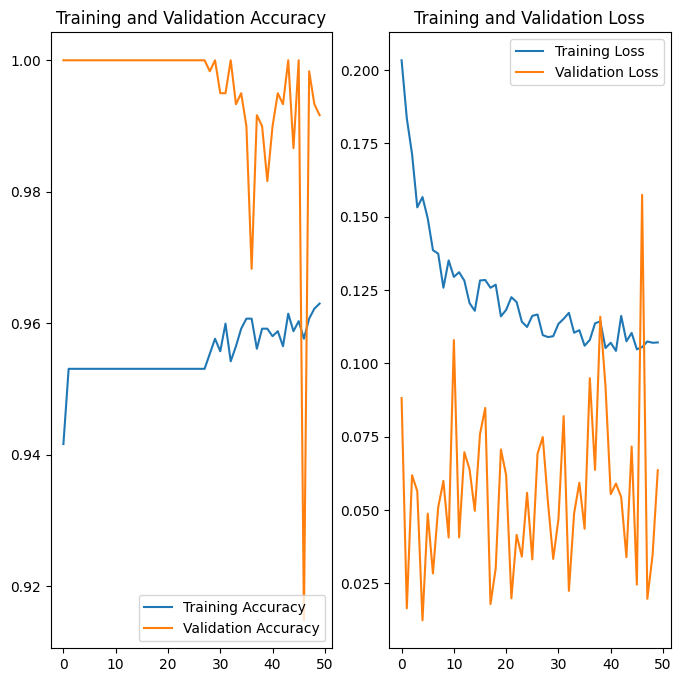

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
